In [79]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
import xgboost
import functools
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from collections import Counter
from imblearn.over_sampling import ADASYN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import plotly.express as px
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score

utilities

In [81]:
def show_crossval_results(scores):
    """
    Display cross validation scores.

    Parameters
    ----------
    scores  array
        cross validation scores
    """
    print("Scores:",scores)
    print("Mean:", round(scores.mean(),2))
    print("Std:", round(scores.std(),2))



class TryClassifier:
    """
    Class to try out different classifiers
    """

    def __init__(self, Xtrain, ytrain, Xtest,
    classifier = RandomForestClassifier()):
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xtest = Xtest
        self.method = classifier
    
    def __call__(self):
        clf = self.method      
        clf_f = clf.fit(self.Xtrain,self.ytrain)
        f_importance = clf_f.feature_importances_
        y_train_pred = cross_val_predict(
            clf,self.Xtrain, self.ytrain, cv = 5
            ) 
        clfcv_scores = cross_val_score(
            clf, self.Xtrain,self.ytrain, cv = 5,
            scoring = "accuracy")
        return y_train_pred, clfcv_scores,f_importance




In [4]:
main_dir = r"P:\Spironolactone\Tobii\processed_eye_tracking_data"
acute_name = "study_day_scores_et.csv"

acute_df = pd.read_csv(os.path.join(main_dir,acute_name))

Retain only specific columns for further analysis.

In [5]:
ctq_cols = (
    acute_df.filter(like = "ctq",axis = 1).columns.tolist()
    )
retain_cols = [
    "stai_trait", "erq_cra","erq_sup","num_outlying_frames",
    "diff_panas_t3_pos","diff_panas_t3_neg"
    ] + ctq_cols

# input features
X = acute_df.loc[:,retain_cols]

Make pipeline. Impute missing values (affects only to values in eye tracking related data). Use Standard Scaler.

In [6]:
pre_et_pipeline = Pipeline(
    [
        ('imputer',  SimpleImputer(strategy = 'median')),
        ('std_scaler', StandardScaler())
        ]
        )

X = pre_et_pipeline.fit_transform(X)
X_df = pd.DataFrame(
    X,index = acute_df.index, columns = retain_cols
    )

Some basic data exploration.

<AxesSubplot:>

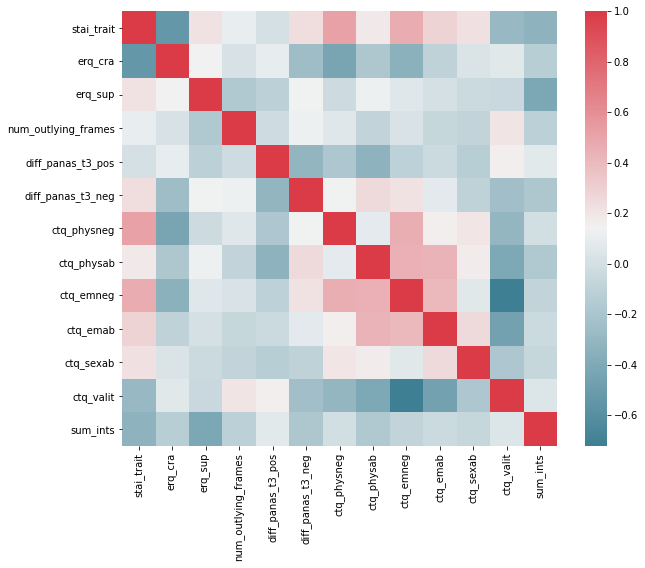

In [56]:
# Correlation.

corr = pd.concat(
    [X_df,acute_df.sum_ints],axis = 1
    ).corr(method = "spearman")

f, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    corr, mask=np.zeros_like(corr, dtype=np.bool),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    square=True, ax=ax
    )

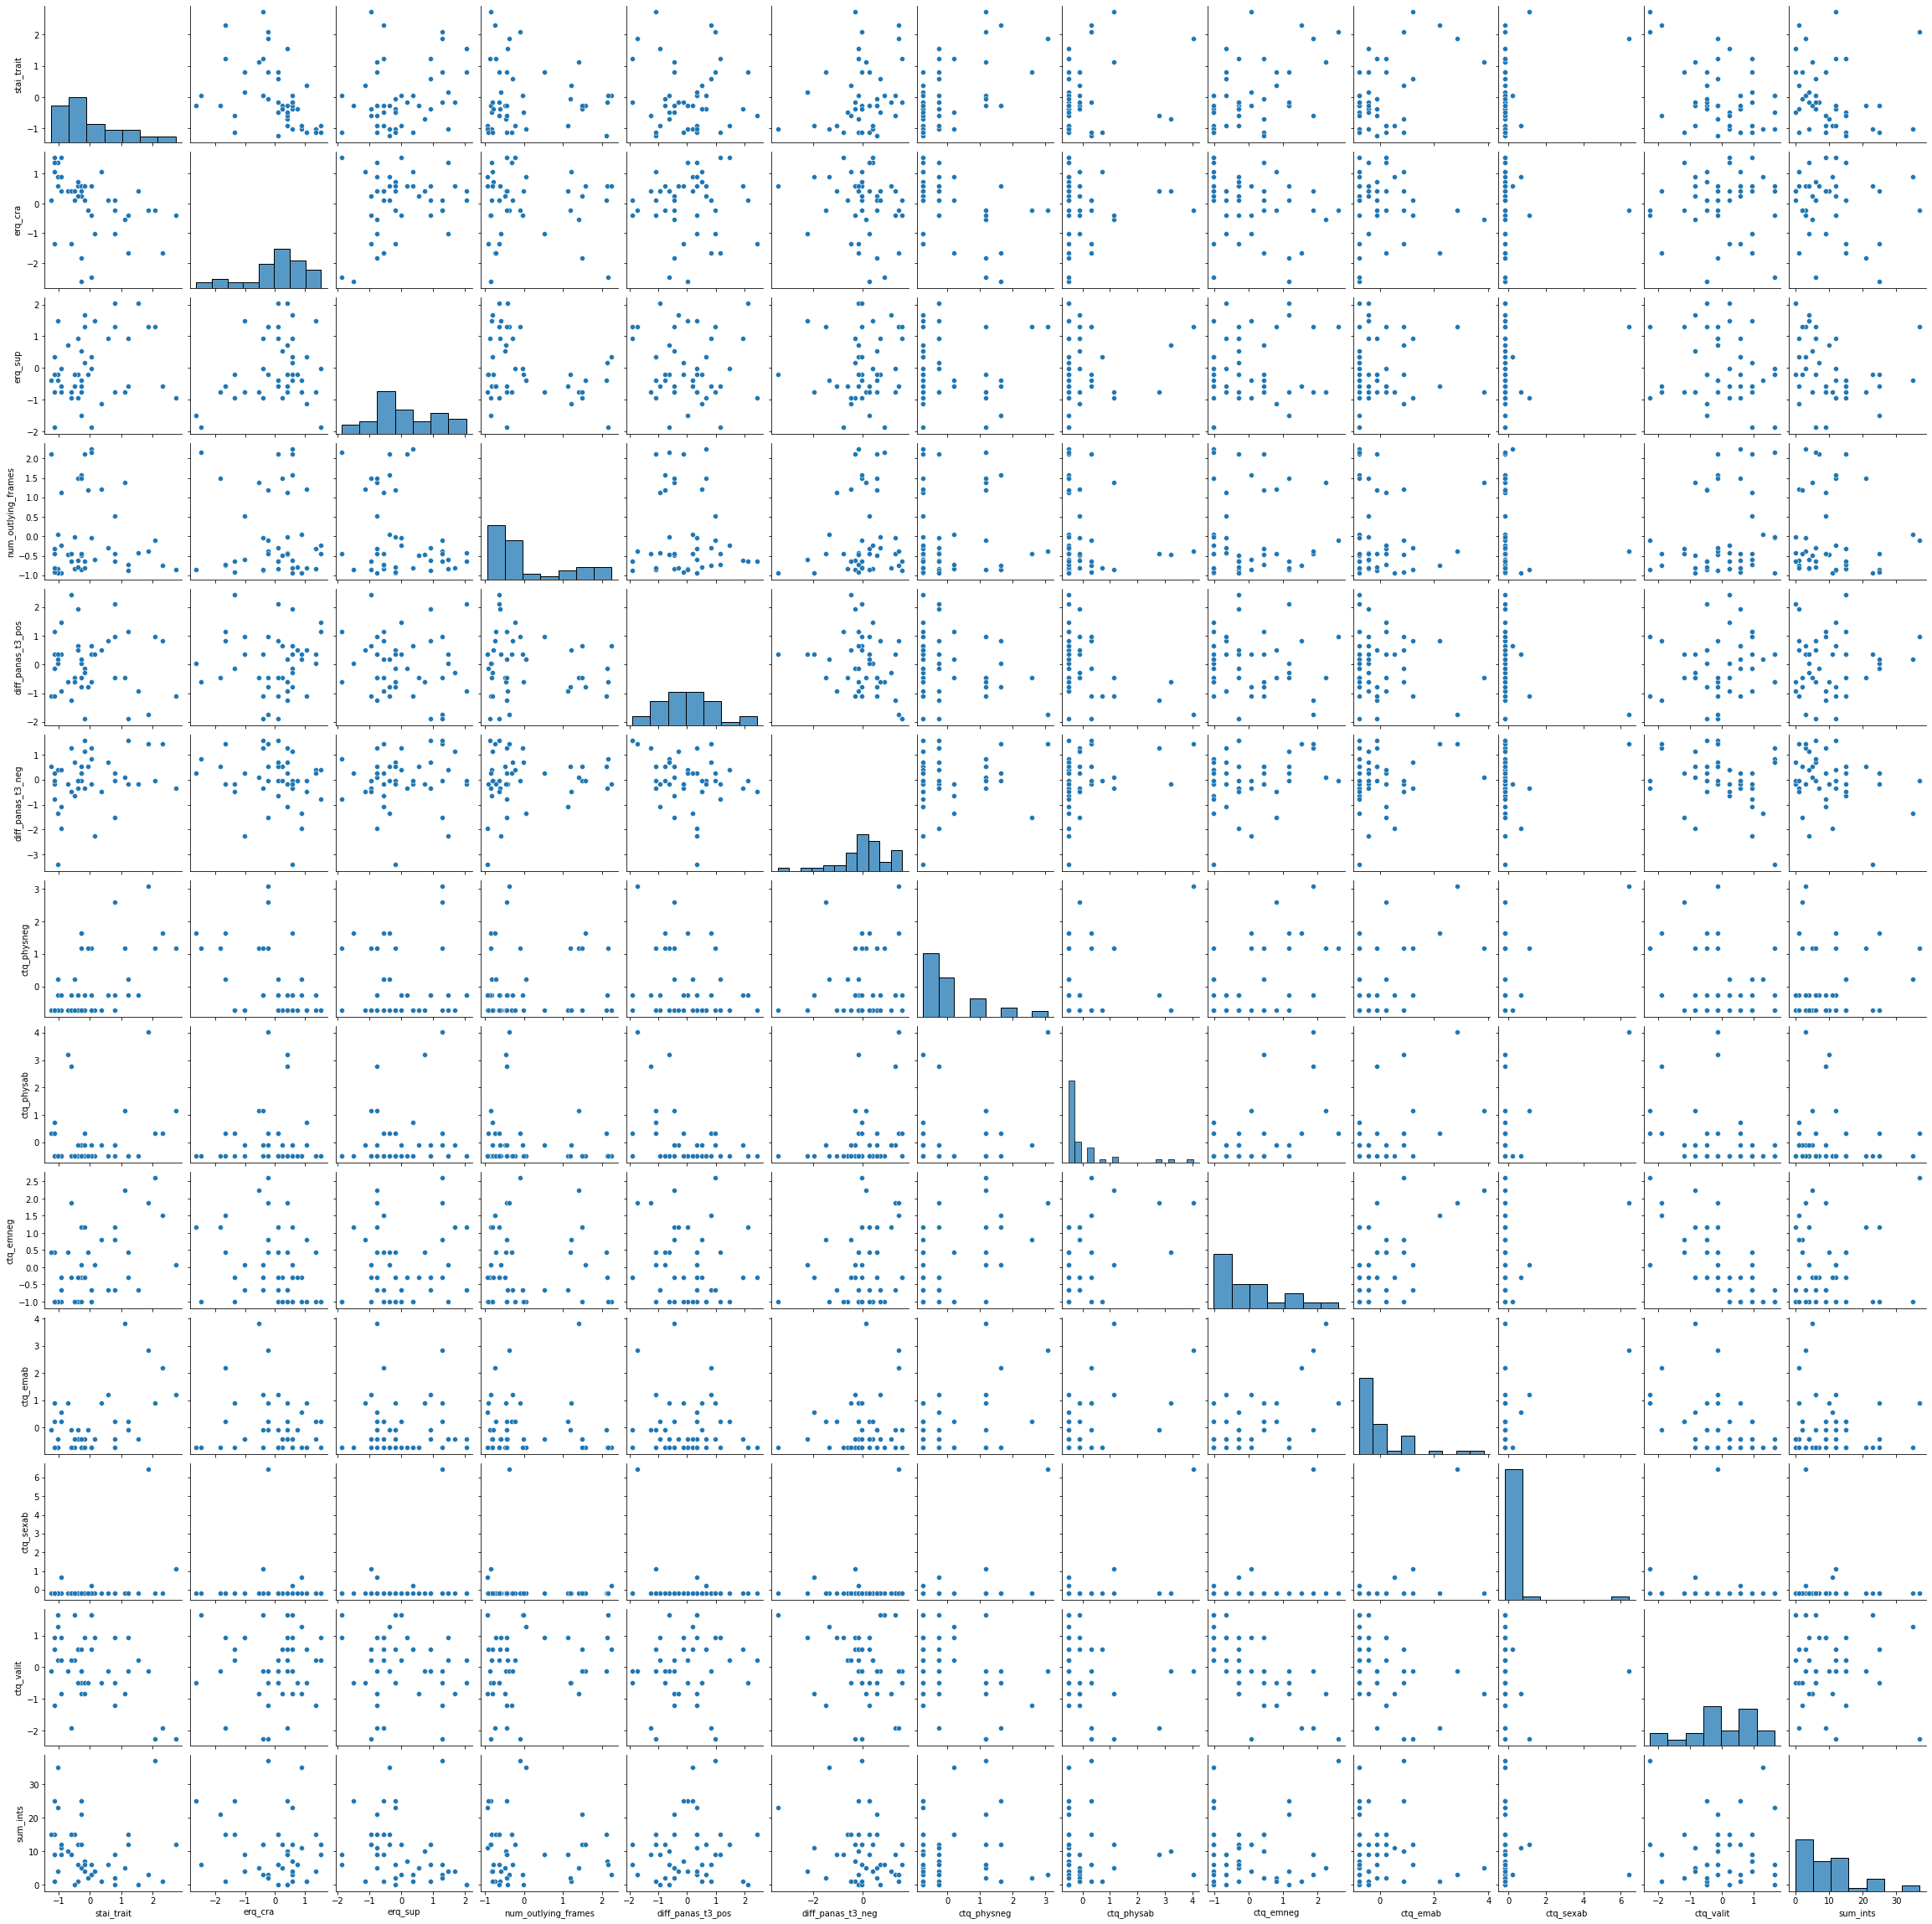

In [55]:
sns.pairplot(pd.concat([X_df,acute_df.sum_ints],axis = 1))

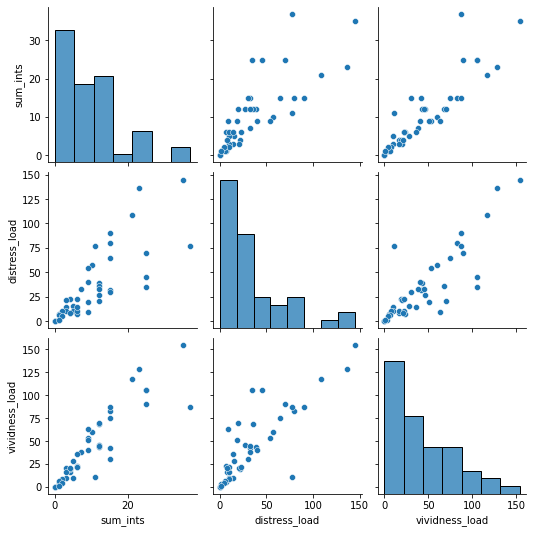

In [57]:
# Pair plots for potential output features.
sns.pairplot(acute_df.loc[:,["sum_ints", "distress_load", "vividness_load"]])

We are going to use the sum of intrusions in the acute phase as our outcome y.

In [65]:
X_train,X_test,y_train,y_test = train_test_split(X_df,y,test_size = 20, random_state = 42)
y = acute_df.sum_ints

In [13]:
# Random Forest regression
rndf = RandomForestRegressor(random_state = 42)
rndf_scores = cross_val_score(rndf, X_train, y_train, 
                            cv = 5)
show_crossval_results(rndf_scores)
rndf_fitted = rndf.fit(X_train,y_train)
print("Test set score:",rndf_fitted.score(X_test,y_test))

Scores: [ 0.33906405 -1.133325    0.11343323 -1.24376829 -1.27058759]
Mean: -0.64
Std: 0.71
Test set score: 0.022394291417165757


gradient boosting regressor

In [59]:
gbrt = GradientBoostingRegressor(random_state = 42)#.fit(X_train,y_train)
gbrt_scores = cross_val_score(gbrt, X_train, y_train, 
                            cv = 5)
show_crossval_results(gbrt_scores)
gbrt_fitted = gbrt.fit(X_train,y_train)
y_pred_gbrt = gbrt.predict(X_test)
res_gbrt = y_pred_gbrt-y_test
print(
    "Test set score:",gbrt_fitted.score(X_test,y_test)
    )

Scores: [ 4.82983911e-01  3.07750547e-01 -1.75810013e-04  4.96427373e-01
 -4.58994033e-01]
Mean: 0.17
Std: 0.36
Test set score: 0.6399284321608334


xgboost

In [60]:
xgb = xgboost.XGBRegressor()
xgb_scores = cross_val_score(xgb, X_train, y_train, 
                            cv = 5)
show_crossval_results(xgb_scores)
xgb_fitted = xgb.fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)
res_xgb = y_pred_xgb-y_test
print(
    "Test set score:", xgb.score(X_test,y_test)
)

Scores: [ 0.6712589   0.49158896 -0.29400305  0.30137983 -0.13589215]
Mean: 0.21
Std: 0.37
Test set score: 0.5492573036578923


The problem with the data set is that we are interested in the very limited number of subjects reporting a higher-than-average number of intrusions.
Unfortunately, this is an issue 

In [61]:
ys_df = acute_df.loc[:,["id","sum_ints"]]
lof_ys = LocalOutlierFactor(n_neighbors=10)
ys_df["labels"] = lof_ys.fit_predict(ys_df["sum_ints"].values.reshape(-1,1))
px.scatter(ys_df, x = "id", y = [ "sum_ints"], color = "labels" )

In [62]:
yc = ys_df.labels
X_ovsamp,y_ovsamp = ADASYN(random_state = 42).fit_resample(X_df,yc)
print(Counter(y_ovsamp).items())

dict_items([(1, 38), (-1, 36)])


In [69]:
clfs = [
    RandomForestClassifier(random_state = 42),
    AdaBoostClassifier(random_state = 42),
    GradientBoostingClassifier(random_state = 42)
    ]

clf_names = [
    t.__class__.__name__ for t in clfs
    ]

y_train_preds = []
cvscores = []
fimps = []
X_train,X_test,y_train,y_test = train_test_split(
    X_ovsamp,y_ovsamp,test_size = 20, random_state = 42
    )

for clf in clfs:
    test_classification = TryClassifier(
        X_train,y_train,X_test,classifier = clf
        )
    y_train_pred,cvscore,fimportance= test_classification()
    y_train_preds.append(y_train_pred)
    cvscores.append(cvscore)
    fimps.append(fimportance)

In [70]:
keys = clf_names
vals = [val for val in fimps]
fimps_dict = dict(zip(keys,vals))
feature_importances_df = pd.DataFrame(data = fimps_dict,index = X_ovsamp.columns)
print(feature_importances_df)

                     RandomForestClassifier  AdaBoostClassifier  \
stai_trait                         0.074787                0.12   
erq_cra                            0.172948                0.12   
erq_sup                            0.065279                0.10   
num_outlying_frames                0.052977                0.10   
diff_panas_t3_pos                  0.202711                0.22   
diff_panas_t3_neg                  0.068130                0.08   
ctq_physneg                        0.106668                0.08   
ctq_physab                         0.061965                0.02   
ctq_emneg                          0.067681                0.08   
ctq_emab                           0.050908                0.06   
ctq_sexab                          0.003207                0.00   
ctq_valit                          0.072737                0.02   

                     GradientBoostingClassifier  
stai_trait                         7.608210e-02  
erq_cra                     

<AxesSubplot:>

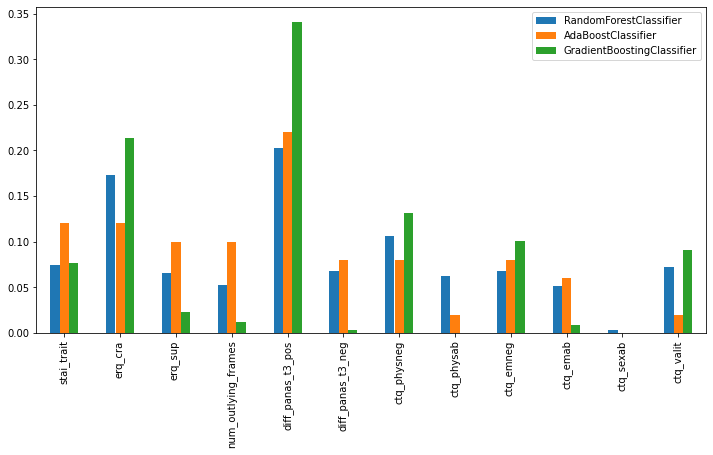

In [71]:
fig,ax = plt.subplots(figsize = (12,6))
feature_importances_df.plot.bar(ax=ax)

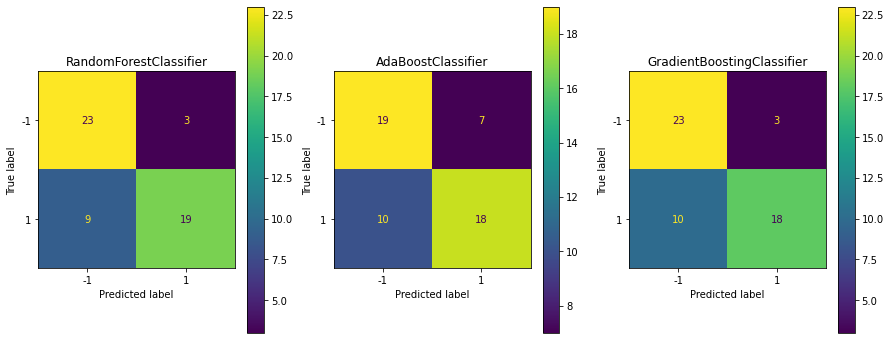

In [73]:
fig,ax = plt.subplots(1,3, figsize = (15,6))

for i,preds in enumerate(y_train_preds):
    disp = ConfusionMatrixDisplay(
        confusion_matrix = confusion_matrix(y_train,preds),display_labels = y_test.unique()
        )

    disp.plot(ax = ax[i])
    ax[i].title.set_text(clf_names[i])

In [74]:
param_grid = [
    {
        "n_estimators": [5,10,20,30],
        "max_depth": [3,5,10,15],
        "max_leaf_nodes": [4,6,8,10]
        }
]

rndf_clf = RandomForestClassifier()
grid_search = GridSearchCV(rndf_clf,param_grid,cv = 5, return_train_score=True)
grid_search.fit(X_ovsamp,y_ovsamp)

print(
    f"Best params: {grid_search.best_params_}"
    )
print(
    f"Best estimator: {grid_search.best_estimator_}"
    )

Best params: {'max_depth': 5, 'max_leaf_nodes': 10, 'n_estimators': 20}
Best estimator: RandomForestClassifier(max_depth=5, max_leaf_nodes=10, n_estimators=20)


Implement best estimator.

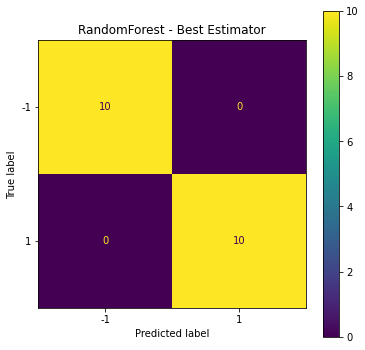

In [76]:
rndf_clf_best = RandomForestClassifier(
    n_estimators = 20, max_depth = 5, max_leaf_nodes=10
    ).fit(X_ovsamp,y_ovsamp)
rndf_best_pred = rndf_clf_best.predict(X_test)
fig,ax = plt.subplots(figsize = (6,6))
disp = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test,rndf_best_pred),
    display_labels = y_test.unique()
    )
disp.plot(ax=ax)
ax.title.set_text("RandomForest - Best Estimator")

Compare to Gradient Boosting classifier

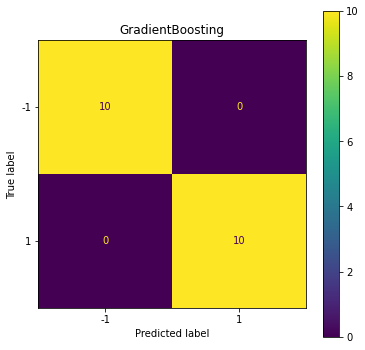

In [77]:
gbt_clf = GradientBoostingClassifier().fit(X_ovsamp,y_ovsamp)
gbt_pred = gbt_clf.predict(X_test)
fig,ax = plt.subplots(figsize = (6,6))
disp = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test,gbt_pred),
    display_labels = y_test.unique()
    )
disp.plot(ax=ax)
ax.title.set_text("GradientBoosting")

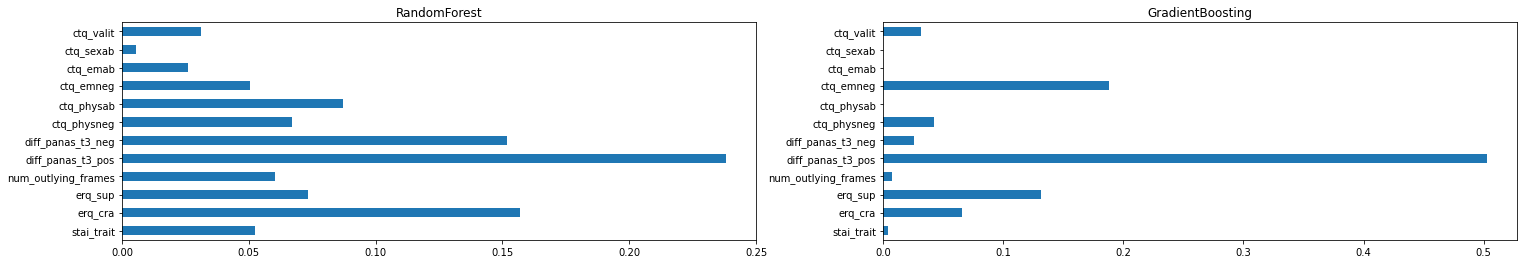

In [78]:
fig,ax = plt.subplots(1,2, figsize = (25,4))
feat_imp_rndf = pd.Series(
    rndf_clf_best.feature_importances_,index = X_ovsamp.columns
    ).plot(kind = "barh",ax = ax[0])
feat_imp_gbt = pd.Series(
    gbt_clf.feature_importances_,index = X_ovsamp.columns
    ).plot(kind = "barh",ax = ax[1])
ax[0].title.set_text("RandomForest")
ax[1].title.set_text("GradientBoosting")